In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pickle as pkl
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
#import seaborn as sns

import scib_metrics as sm
import sys
import os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]+['eval','cleaned','']))
#from metrics import ilisi,asw_batch

%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option('display.max_columns', None)

# Define the path to the directory you want to change to
new_directory = '/scratch365/eaboelno/cVAE_analysis/sysVI/'

# Use os.chdir() to change the working directory
os.chdir(new_directory)

# Load and check data 

In [ ]:
#mdata_filtered.write_h5ad('./sysVI/Macnair_QC_resetX_TRIMMED_BACKUP.h5ad')

In [3]:
adata = sc.read_h5ad('./Adams_QC_resetX_TRIMMED_BACKUP.h5ad')
adata

AnnData object with n_obs × n_vars = 21383 × 18956
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

In [4]:
pdata = sc.read_h5ad('./Pandey_QC_resetX_TRIMMED_BACKUP.h5ad')
pdata

AnnData object with n_obs × n_vars = 41938 × 20384
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

In [6]:
sdata = sc.read_h5ad('./Shen_QC_resetX_TRIMMED_BACKUP.h5ad')
sdata

AnnData object with n_obs × n_vars = 48696 × 18318
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

# Calc HVG on merged mouse data- both methods

In [7]:
adata_mm=sc.concat([adata, pdata, sdata],
                join='outer',
                index_unique='_', keys=['adams','pandey', 'shen'])
adata_mm

AnnData object with n_obs × n_vars = 112017 × 21349
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    layers: 'counts', 'log1p_norm'

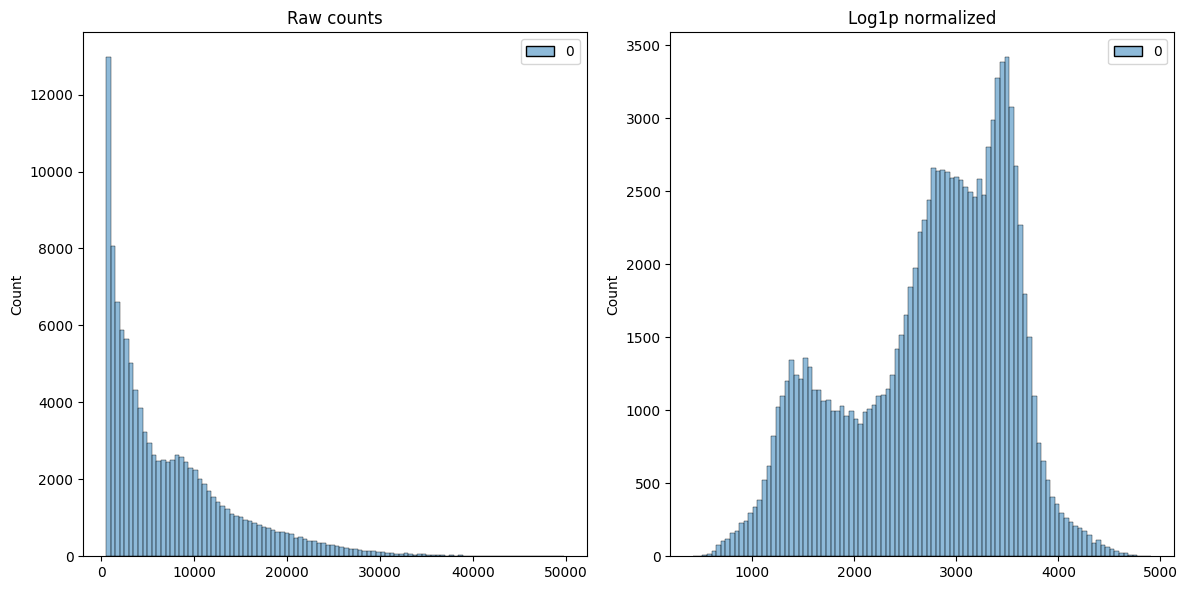

In [8]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(adata_mm.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(adata_mm.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

In [10]:
print(adata_mm.X[:10, :10])

  (0, 5)	0.51401925
  (3, 7)	0.52225447
  (3, 5)	0.8635851
  (3, 3)	0.52225447
  (4, 9)	0.53151506
  (4, 5)	0.53151506
  (5, 9)	0.5346283
  (5, 7)	0.88113075
  (5, 5)	1.1379743
  (5, 4)	0.5346283
  (5, 2)	0.5346283
  (6, 5)	0.5380162
  (8, 5)	0.9055519
  (9, 9)	0.5659346
  (9, 5)	1.7167768


In [11]:
print(adata_mm.raw.X[:10, :10])

  (0, 5)	1
  (3, 8)	1
  (3, 5)	2
  (3, 3)	1
  (4, 5)	1
  (5, 8)	2
  (5, 5)	3
  (5, 4)	1
  (5, 2)	1
  (6, 5)	1
  (8, 5)	2
  (9, 5)	6


In [12]:
# Create an empty dictionary to store the mapping
gene_id_mapping = {}

# Iterate through each AnnData object and create the mapping
for ad in [adata, pdata, sdata]:
    if 'mouse_gene_id' in ad.var.columns:
        # Iterate through the genes in this AnnData object
        for gene, mouse_gene_id in zip(ad.var.index, ad.var['mouse_gene_id']):
            gene_id_mapping[gene] = mouse_gene_id

            # Print the combined dictionary
print(list(gene_id_mapping.items())[:10])

[('0610005C13Rik', 'ENSMUSG00000109644'), ('0610009B22Rik', 'ENSMUSG00000007777'), ('0610009E02Rik', 'ENSMUSG00000086714'), ('0610009L18Rik', 'ENSMUSG00000043644'), ('0610010F05Rik', 'ENSMUSG00000042208'), ('0610010K14Rik', 'ENSMUSG00000020831'), ('0610012G03Rik', 'ENSMUSG00000107002'), ('0610030E20Rik', 'ENSMUSG00000058706'), ('0610038B21Rik', 'ENSMUSG00000097882'), ('0610040B10Rik', 'ENSMUSG00000089889')]


In [13]:
len(gene_id_mapping)

21349

In [14]:
adata_mm.var['mouse_gene_id'] = adata_mm.var.index.map(gene_id_mapping.get)
adata_mm.var

,mouse_gene_id
gene_name,
0610005C13Rik,ENSMUSG00000109644
0610006L08Rik,ENSMUSG00000108652
0610009B22Rik,ENSMUSG00000007777
0610009E02Rik,ENSMUSG00000086714
0610009L18Rik,ENSMUSG00000043644
...,...
mt-Nd3,ENSMUSG00000064360
mt-Nd4,ENSMUSG00000064363
mt-Nd4l,ENSMUSG00000065947


In [15]:
adata_mm.var['mouse_gene_name'] = adata_mm.var.index
adata_mm.var

,mouse_gene_id,mouse_gene_name
gene_name,,
0610005C13Rik,ENSMUSG00000109644,0610005C13Rik
0610006L08Rik,ENSMUSG00000108652,0610006L08Rik
0610009B22Rik,ENSMUSG00000007777,0610009B22Rik
0610009E02Rik,ENSMUSG00000086714,0610009E02Rik
0610009L18Rik,ENSMUSG00000043644,0610009L18Rik
...,...,...
mt-Nd3,ENSMUSG00000064360,mt-Nd3
mt-Nd4,ENSMUSG00000064363,mt-Nd4
mt-Nd4l,ENSMUSG00000065947,mt-Nd4l


In [16]:
adata_mm.obs['batch'] = adata_mm.obs['batch'].astype(str)

In [17]:
adata_mm.write_h5ad('./adata_mm_merged.h5ad')

# Calculate HVG for log1p

In [27]:
adata_cr = adata.copy()

In [20]:
pdata_cr = pdata.copy()

In [21]:
sdata_cr = sdata.copy()

In [28]:
adata_cr

AnnData object with n_obs × n_vars = 21383 × 18956
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

In [29]:
sc.pp.highly_variable_genes(
     adata=adata_cr, n_top_genes=6000, layer='log1p_norm', flavor='cell_ranger', batch_key='batch', subset=False)
adata_cr.shape

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

(21383, 18956)

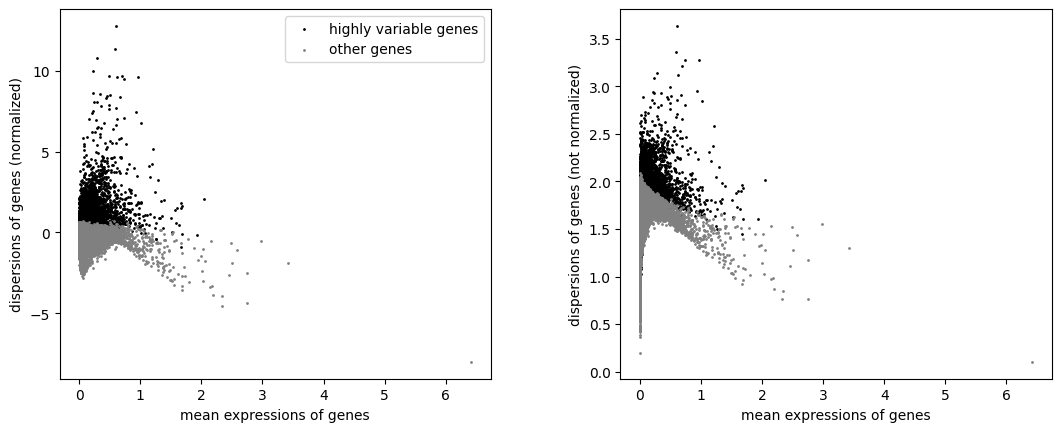

In [30]:
sc.pl.highly_variable_genes(adata_cr)

highly_variable_nbatches
0    5288
1    3118
2    2512
3    2077
4    1662
5    1380
6    1203
7     867
8     849
Name: count, dtype: int64

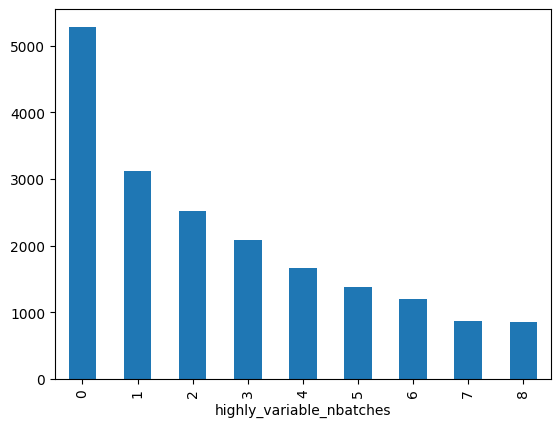

In [31]:
n_batches = adata_cr.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

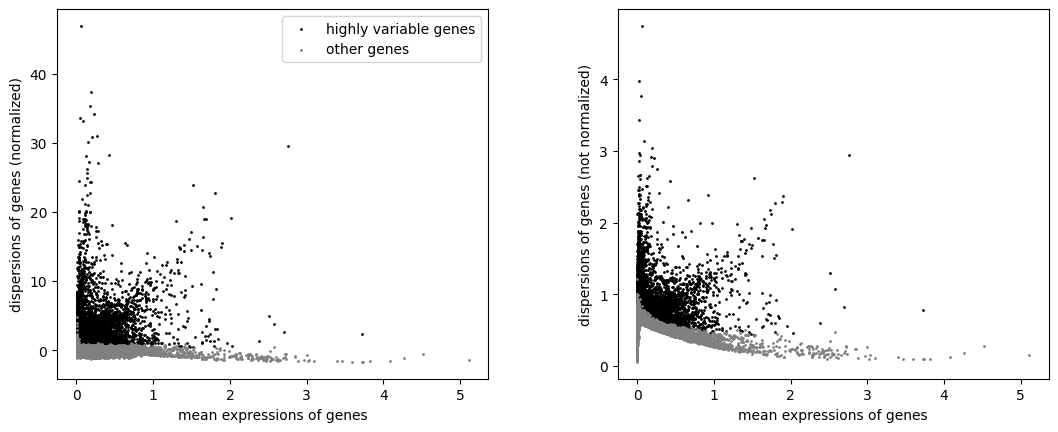

In [32]:
sc.pp.highly_variable_genes(
     adata=pdata_cr, n_top_genes=6000, layer='log1p_norm', flavor='cell_ranger', batch_key='batch', subset=False)
sc.pl.highly_variable_genes(pdata_cr)

highly_variable_nbatches
0     6631
1     2855
2     2040
12    1514
3     1483
4     1068
5      804
11     737
10     729
6      701
7      622
8      601
9      599
Name: count, dtype: int64

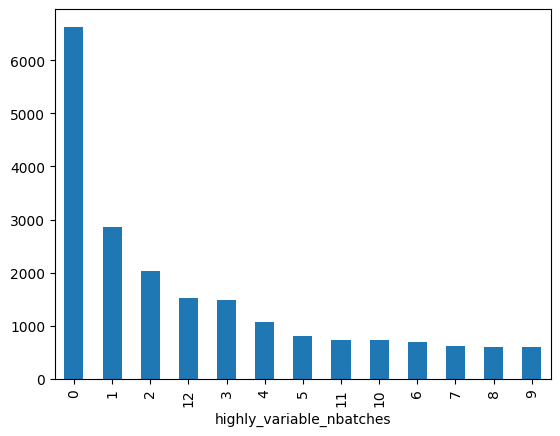

In [33]:
n_batches = pdata_cr.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

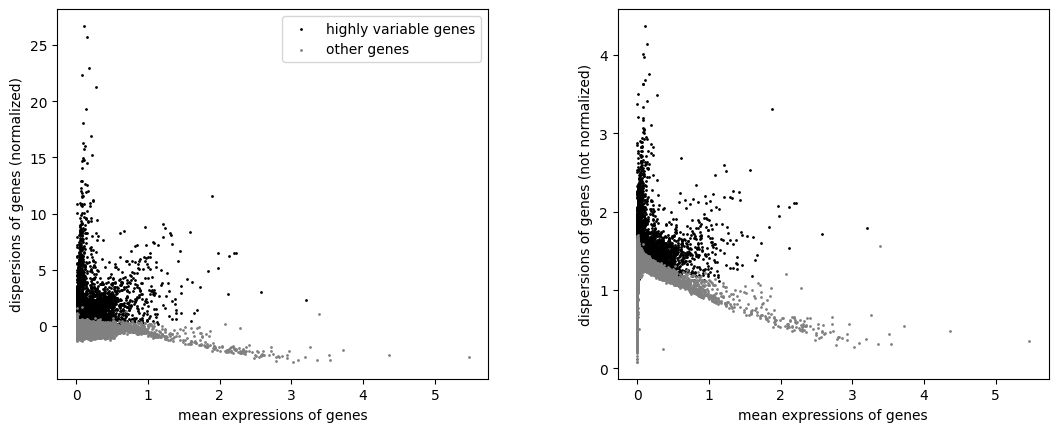

In [34]:
sc.pp.highly_variable_genes(
     adata=sdata_cr, n_top_genes=6000, layer='log1p_norm', flavor='cell_ranger', batch_key='batch', subset=False)
sc.pl.highly_variable_genes(sdata_cr)

highly_variable_nbatches
1     3242
0     2911
2     2841
3     2404
4     1707
5     1330
6     1008
7      771
10     707
8      702
9      695
Name: count, dtype: int64

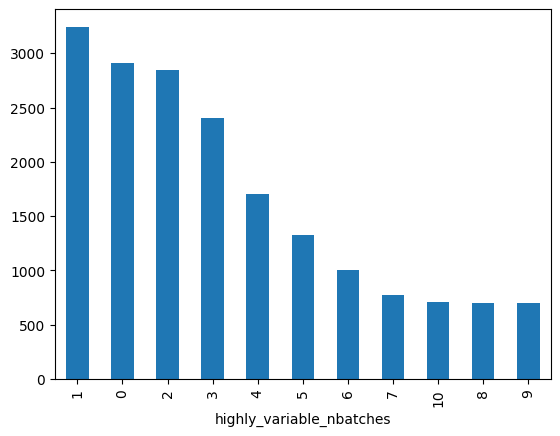

In [35]:
n_batches = sdata_cr.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

# Calculate HVG for counts

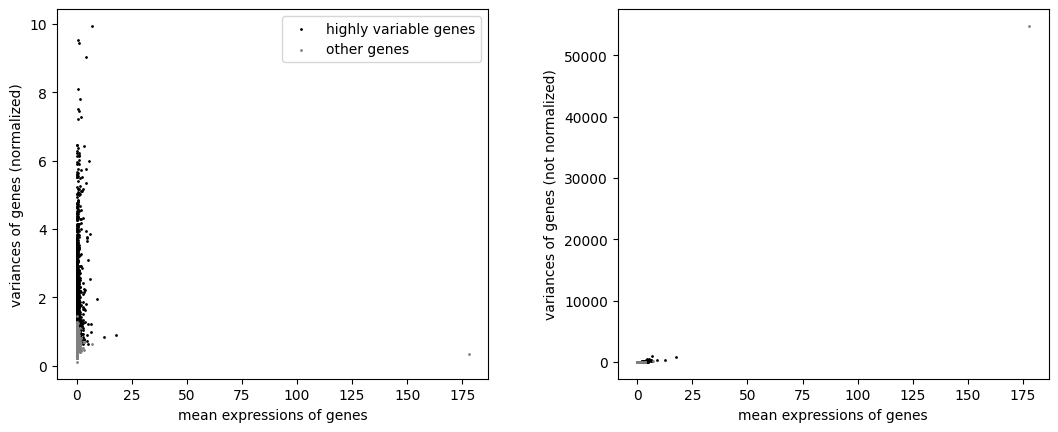

In [37]:
sc.pp.highly_variable_genes(
     adata=adata, n_top_genes=6000, layer='counts', flavor='seurat_v3', batch_key='batch', subset=False)
sc.pl.highly_variable_genes(adata)

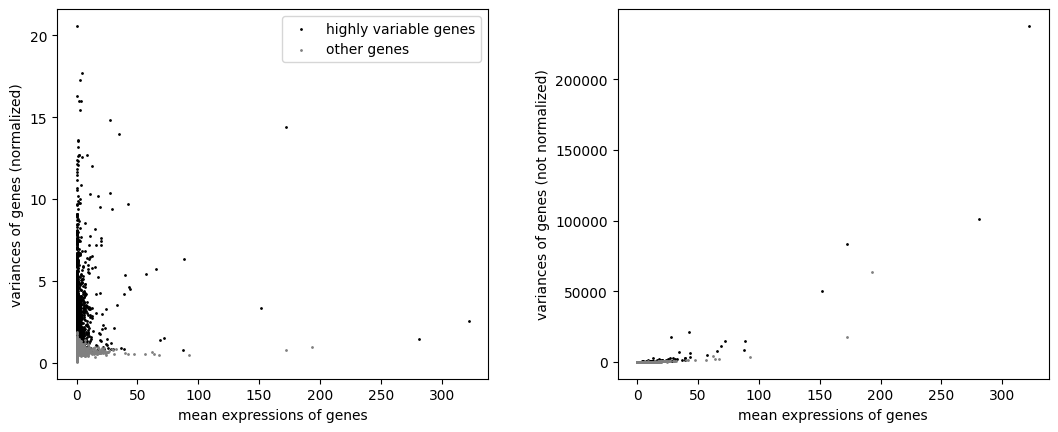

In [38]:
sc.pp.highly_variable_genes(
     adata=pdata, n_top_genes=6000, layer='counts', flavor='seurat_v3', batch_key='batch', subset=False)
sc.pl.highly_variable_genes(pdata)

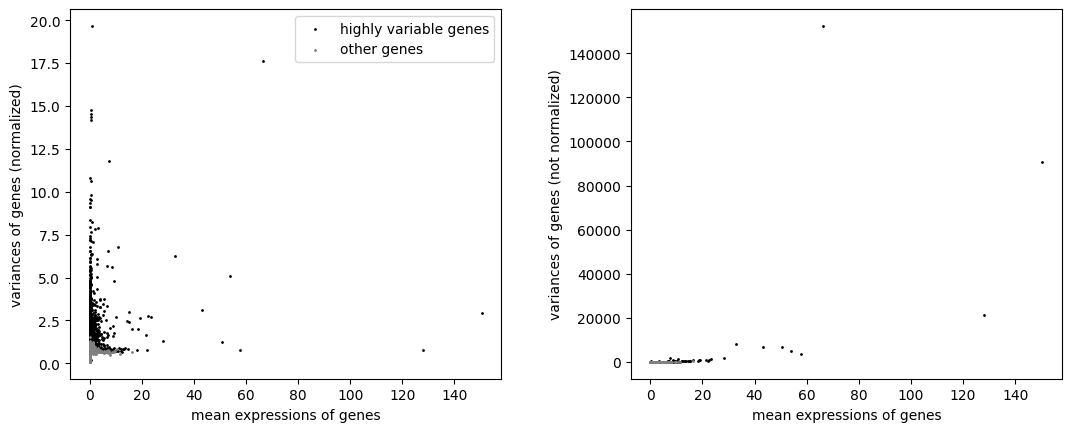

In [39]:
sc.pp.highly_variable_genes(
     adata=sdata, n_top_genes=6000, layer='counts', flavor='seurat_v3', batch_key='batch', subset=False)
sc.pl.highly_variable_genes(sdata)

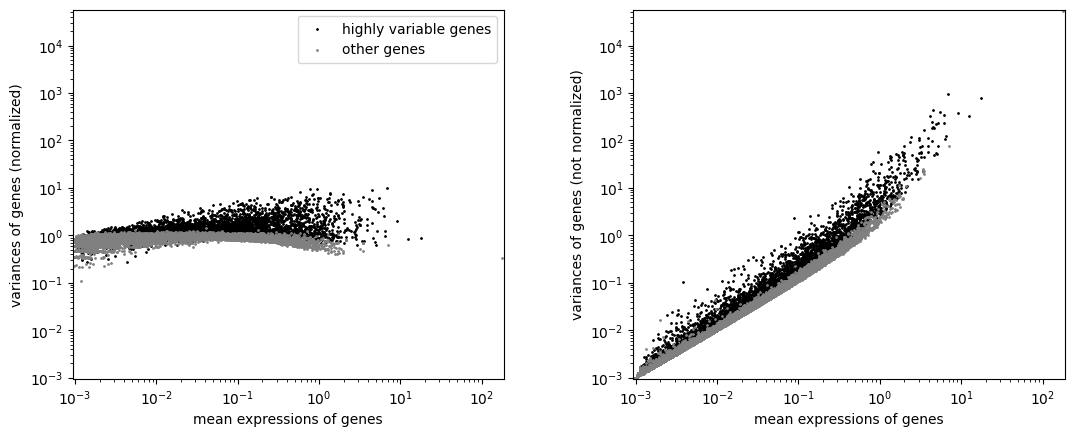

In [43]:
sc.pl.highly_variable_genes(adata, log=True)

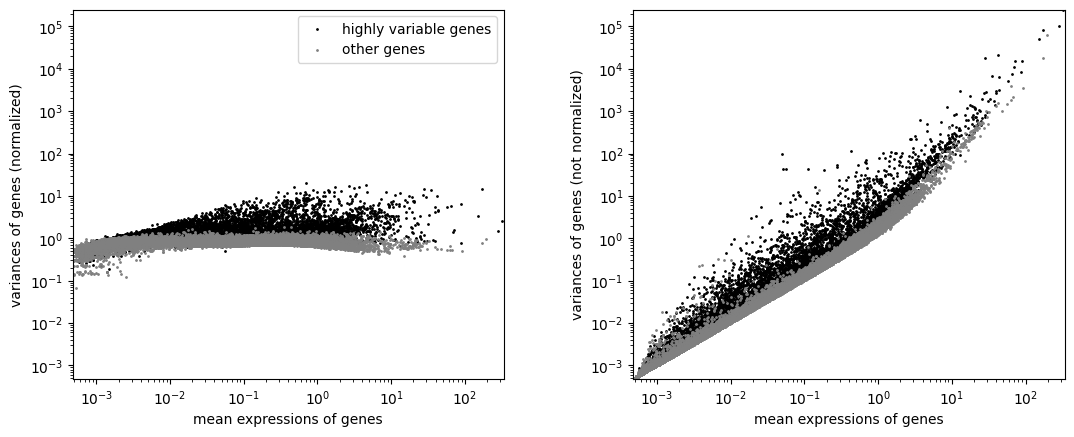

In [44]:
sc.pl.highly_variable_genes(pdata, log=True)

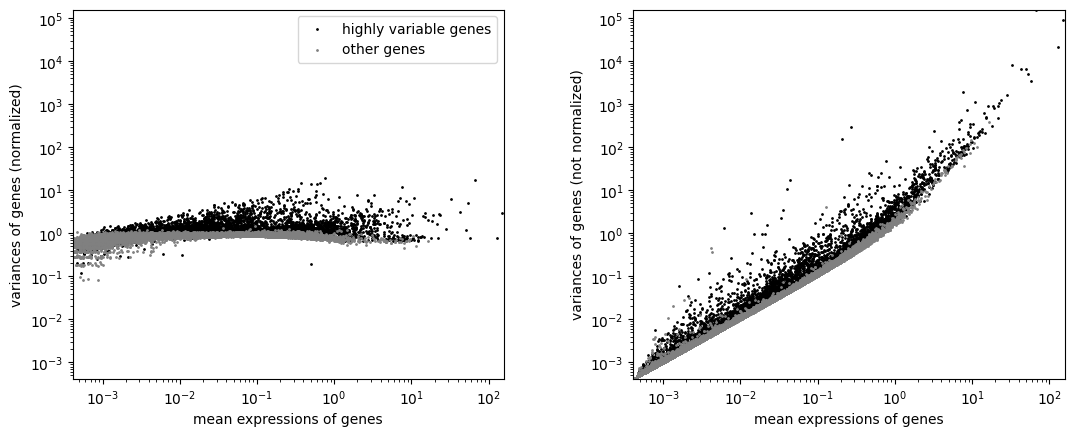

In [45]:
sc.pl.highly_variable_genes(sdata, log=True)

highly_variable_nbatches
0    4964
1    3844
2    2751
3    1860
8    1410
4    1397
5    1014
6     876
7     840
Name: count, dtype: int64

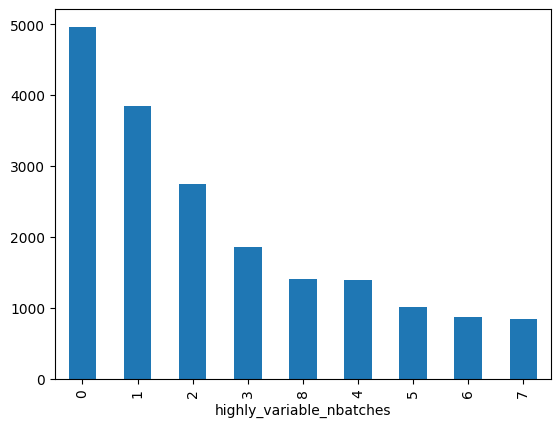

In [40]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
0     7478
1     2486
2     1694
12    1611
3     1251
4      960
5      749
11     742
9      708
8      707
7      682
6      667
10     649
Name: count, dtype: int64

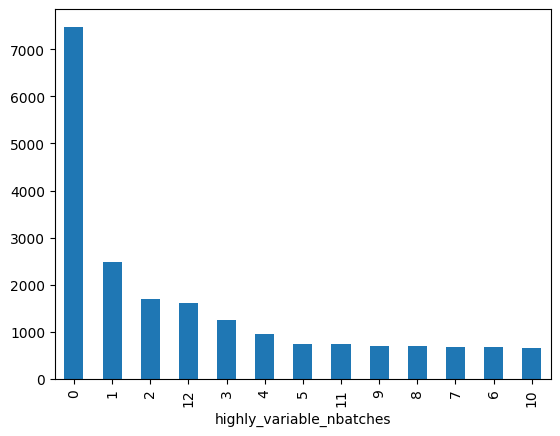

In [41]:
n_batches = pdata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
0     4241
1     3033
2     2281
3     1782
4     1344
5     1140
10     984
6      968
7      876
9      851
8      818
Name: count, dtype: int64

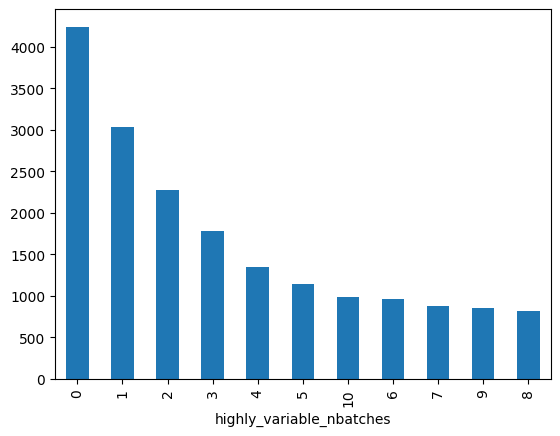

In [42]:
n_batches = sdata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

# Explore HVG overlap in single adata

In [46]:
adata_sub_seur = adata[:, adata.var["highly_variable"]].copy()
adata_sub_seur

AnnData object with n_obs × n_vars = 21383 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [47]:
pdata_sub_seur = pdata[:, pdata.var["highly_variable"]].copy()
pdata_sub_seur

AnnData object with n_obs × n_vars = 41938 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [48]:
sdata_sub_seur = sdata[:, sdata.var["highly_variable"]].copy()
sdata_sub_seur

AnnData object with n_obs × n_vars = 48696 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [49]:
adata_cr_sub = adata_cr[:, adata_cr.var["highly_variable"]].copy()
adata_cr_sub

AnnData object with n_obs × n_vars = 21383 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [50]:
pdata_cr_sub = pdata_cr[:, pdata_cr.var["highly_variable"]].copy()
pdata_cr_sub

AnnData object with n_obs × n_vars = 41938 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [51]:
sdata_cr_sub = sdata_cr[:, sdata_cr.var["highly_variable"]].copy()
sdata_cr_sub

AnnData object with n_obs × n_vars = 48696 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [52]:
common_hvgs_adata=list(set(adata_sub_seur.var_names) & set(adata_cr_sub.var_names))
len(common_hvgs_adata)

2503

In [53]:
common_hvgs_pdata=list(set(pdata_sub_seur.var_names) & set(sdata_cr_sub.var_names))
len(common_hvgs_pdata)

3364

In [54]:
common_hvgs_sdata=list(set(sdata_sub_seur.var_names) & set(sdata_cr_sub.var_names))
len(common_hvgs_sdata)

3602

In [55]:
# Shared HVGs
shared_hvgs=list(set(adata_sub_seur.var_names) & set(pdata_sub_seur.var_names) & 
                 set(sdata_sub_seur.var_names))
len(shared_hvgs)

2364

In [56]:
# Shared HVGs
shared_hvgs=list(set(adata_cr_sub.var_names) & set(pdata_cr_sub.var_names) & 
                 set(sdata_cr_sub.var_names))
len(shared_hvgs)

2093

In [57]:
adata_mm

AnnData object with n_obs × n_vars = 112017 × 21349
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'mouse_gene_name'
    layers: 'counts', 'log1p_norm'

In [59]:
adata_mm_cr = adata_mm.copy()

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

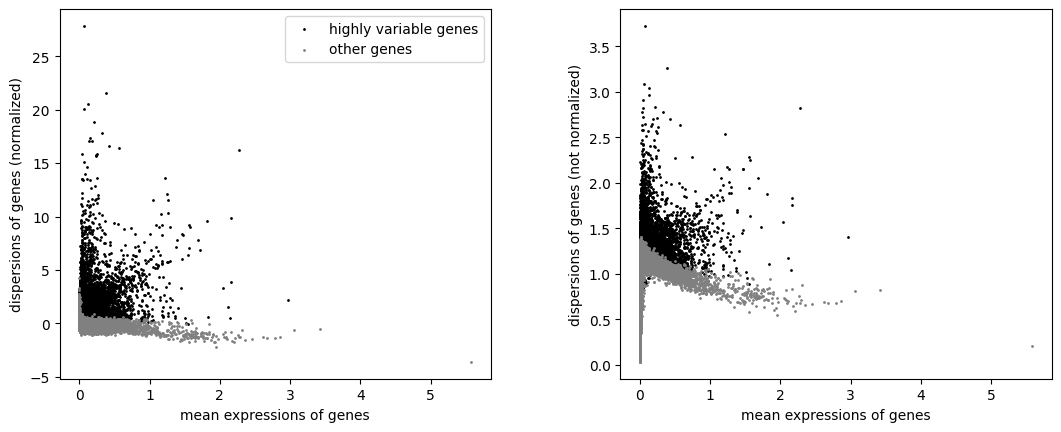

In [60]:
sc.pp.highly_variable_genes(
     adata=adata_mm_cr, n_top_genes=6000, layer='log1p_norm', flavor='cell_ranger', batch_key='batch', subset=False)
sc.pl.highly_variable_genes(adata_mm_cr)

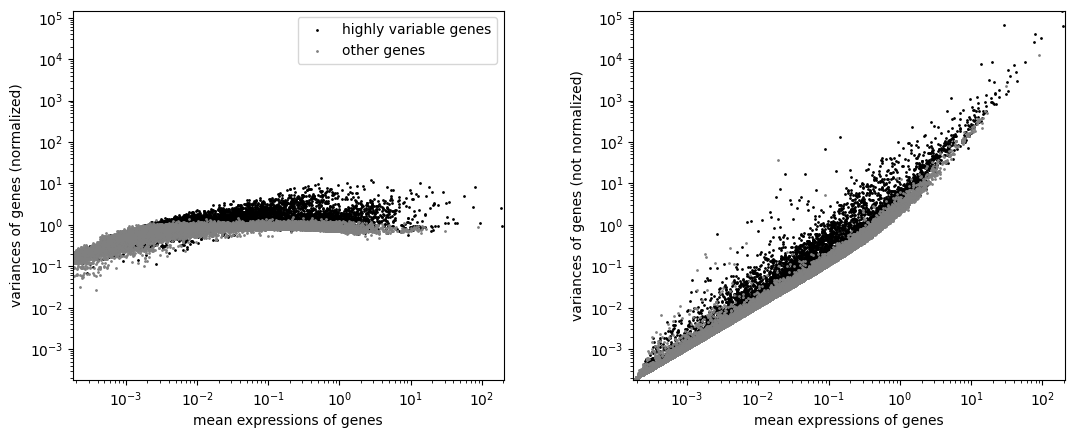

In [61]:
sc.pp.highly_variable_genes(
     adata=adata_mm, n_top_genes=6000, layer='counts', flavor='seurat_v3', batch_key='batch', subset=False)
sc.pl.highly_variable_genes(adata_mm, log=True)

highly_variable_nbatches
2     1882
1     1859
3     1854
4     1616
5     1490
0     1386
6     1260
7     1122
8      893
9      824
10     721
11     577
12     542
13     480
14     448
16     371
17     369
19     368
15     364
22     358
21     350
18     331
20     320
23     291
24     290
25     252
26     211
27     185
28     131
29     113
30      91
Name: count, dtype: int64

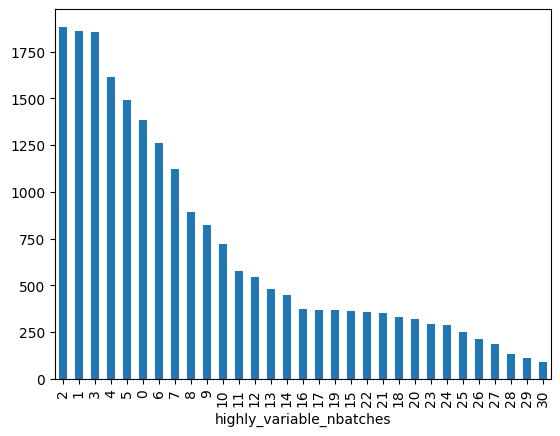

In [62]:
n_batches = adata_mm_cr.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
1     2721
2     2223
0     2138
3     1778
4     1329
5     1113
6      943
7      735
8      682
9      619
11     454
10     429
12     409
13     399
14     394
22     366
15     365
17     356
21     339
19     332
16     327
23     326
20     323
25     311
18     309
24     300
26     293
30     274
27     267
29     253
28     242
Name: count, dtype: int64

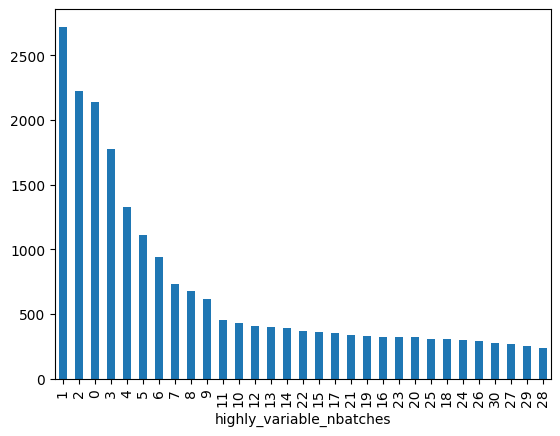

In [63]:
n_batches = adata_mm.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [64]:
adata_mm_cr_sub = adata_mm_cr[:, adata_mm_cr.var["highly_variable"]].copy()
adata_mm_cr_sub

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [65]:
adata_mm_seur = adata_mm[:, adata_mm.var["highly_variable"]].copy()
adata_mm_seur

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [66]:
common_hvgs_mm=list(set(adata_mm_seur.var_names) & set(adata_mm_cr_sub.var_names))
len(common_hvgs_mm)

3517

# Save merged files for downstream use

In [67]:
adata_mm

AnnData object with n_obs × n_vars = 112017 × 21349
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [68]:
adata_mm.write_h5ad('./adata_mm_merged_totaldata.h5ad')

In [69]:
adata_mm_cr_sub

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [70]:
adata_mm_cr_sub.write_h5ad('./adata_mm_merged_cr6kHVG.h5ad')

In [71]:
adata_mm_seur

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [72]:
adata_mm_seur.write_h5ad('./adata_mm_merged_seur6kHVG.h5ad')

# Show common genes between merged and single data

In [74]:
# names of loaded/generated vectors subset for HVG

#adata
#adata_cr_sub, adata_sub_seur

#pdata
#pdata_cr_sub, pdata_sub_seur

#sdata
#sdata_cr_sub, sdata_sub_seur

# merged
#adata_mm_cr_sub, adata_mm_seur

In [75]:
common_seurat_indiv=list(set(adata_sub_seur.var_names) & set(pdata_sub_seur.var_names)
                        & set(sdata_sub_seur.var_names))
len(common_seurat_indiv)

2364

In [78]:
# Shared HVGs
shared_hvgs_seurat = list(set(adata_mm_seur.var_names).intersection(common_seurat_indiv))
len(shared_hvgs_seurat)

2307

In [77]:
common_cr_indiv=list(set(adata_cr_sub.var_names) & set(pdata_cr_sub.var_names)
                        & set(sdata_cr_sub.var_names))
len(common_cr_indiv)

2093

In [79]:
# Shared HVGs
shared_hvgs_cr = list(set(adata_mm_cr_sub.var_names).intersection(common_cr_indiv))
len(shared_hvgs_cr)

2093